In [64]:
import cv2
import numpy as np
import os 
from matplotlib import pyplot as plt
import time 
import mediapipe as mp

# 2.KEYPOINTS USING MP HOLISTIC


In [65]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [66]:
def mediapipe_detection(image, model):
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False # IMAGE IS NO LONGER WRITEABLE
    results = model.process(image) # MAKE PRIDICTION
    image.flags.writeable = True # IMAGE IS NOW WRITEABLE
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) # COLOR CONVERSION RGB 2 BGR
    return image, results

In [67]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [68]:
def draw_styled_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,110,10),thickness = 1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1)
                              )
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10),thickness = 2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121),thickness=2,circle_radius=2)
                              )
                             
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76),thickness =2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250),thickness=2,circle_radius=2)
                              )
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(245,117,66),thickness = 2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230),thickness=2,circle_radius=2)
                              )

In [ ]:
cap = cv2.VideoCapture(0)
# SET MEDIAPIPE MODEL
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # MAKE DETECTIONS 
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image, results)
         
        cv2.imshow('Opencv Feed', image)
    
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

    

In [69]:
draw_landmarks(frame,results)

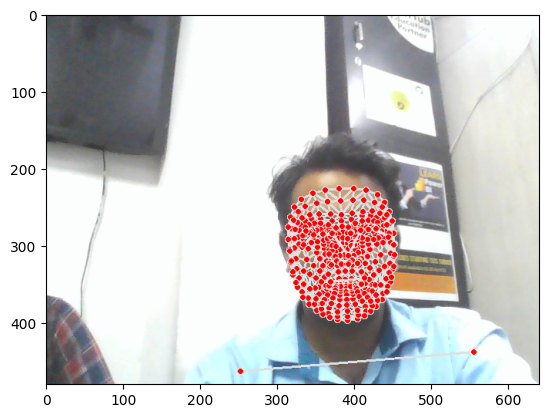

In [70]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# EXTRACRTION KEYPOINTS VALUES


In [71]:
results.pose_landmarks.landmark[0].visibility


0.9999292492866516

In [72]:
pose=[]
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [73]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face= np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
np.concatenate([pose,face,lh,rh]).shape

(2130,)

In [74]:
face= np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [75]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face= np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    # print('concat', np.concatenate([pose,face,lh,rh]))
    
    return np.concatenate([pose,face,lh,rh])[:1600]

In [76]:
extract_keypoints(results).shape

(1600,)

# setup folders for collection

In [77]:
# path for exported data, numpy array
DATA_PATH = os.path.join('MP_DATA')

# actions that we try to detect
actions = np.array(['hello','thanks','iloveyou'])

# thirty videos worth of data
no_sequences = 30

# videos are going to be 30 frames in length
sequence_length = 30 

In [78]:
print(actions)

['hello' 'thanks' 'iloveyou']


In [79]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
               pass 
              
    print(sequence)

29
29
29


# Collect keypoints values for training and testing

In [80]:
cap = cv2.VideoCapture(0)
# SET MEDIAPIPE MODEL
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        # Loop through sequences aka vodeos
        for sequence in range(no_sequences):
            #Loop through videos length aka squence length
            for frame_num in range(sequence_length):

                # read feed
                ret, frame = cap.read()

                # MAKE DETECTIONS 
                image, results = mediapipe_detection(frame, holistic)
                print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # Apply collections logic
                if frame_num == 0:
                    cv2.putText(image,'STARTING COLLECTION',(120,200),
                                cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4,cv2.LINE_AA)
                    cv2.putText(image,'Collecting frames for{} video number{}'.format(action,sequence),(15,12),
                                cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image,'Collecting frames for{} video number{}'.format(action,sequence),(15,12),
                                cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                # New export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH,action,str(sequence), str(frame_num))
                np.save(npy_path,keypoints)

                # show to screen
                cv2.imshow('Opencv Feed', image)
    
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
cap.release()
cv2.destroyAllWindows()

    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

# preprocess Data and createlabels anda features

In [81]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [82]:
label_map = {label:num for num, label in enumerate(actions)}

In [83]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [84]:
no_sequences

30

In [85]:
sequences, labels = [], []
shapes = {}
total = 0
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            try:shapes[res.shape] += 1
            except:shapes[res.shape] = 0
            total += 1
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [86]:
shapes, total

({(1600,): 2699}, 2700)

In [87]:
np.array(sequences)

array([[[ 0.68646002,  0.53057992, -1.39271879, ...,  0.50246155,
          0.11867862,  0.        ],
        [ 0.58637792,  0.47093815, -1.23477483, ...,  0.44032335,
          0.09457614,  0.        ],
        [ 0.58027369,  0.46083242, -1.22221875, ...,  0.44264415,
          0.09059564,  0.        ],
        ...,
        [ 0.64149863,  0.46710506, -1.50112152, ...,  0.46001941,
          0.09854452,  0.        ],
        [ 0.65208977,  0.48146603, -1.55206132, ...,  0.46781909,
          0.10036818,  0.        ],
        [ 0.67626274,  0.48777407, -1.69232559, ...,  0.46909836,
          0.10286958,  0.        ]],

       [[ 0.69895679,  0.48465303, -1.68067908, ...,  0.46960363,
          0.10688451,  0.        ],
        [ 0.69148165,  0.48731852, -1.67873216, ...,  0.46996817,
          0.09279092,  0.        ],
        [ 0.695557  ,  0.4865658 , -1.64406717, ...,  0.47051939,
          0.09648503,  0.        ],
        ...,
        [ 0.74067432,  0.47944802, -1.11644089, ...,  

In [88]:
np.array(labels).shape

(90,)

In [89]:
X = np.array(sequences)

In [90]:
X.shape

(90, 30, 1600)

In [91]:
y = to_categorical(labels).astype(float)

In [92]:
y.shape

(90, 3)

In [93]:
y.shape

(90, 3)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5)

In [95]:
X.shape

(90, 30, 1600)

# Build and train LSTM neural network

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard


In [138]:
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [139]:
model = Sequential()
model.add(LSTM(64,return_sequences=True,activation='relu',input_shape=(30,1600)))
model.add(LSTM(128,return_sequences=True,activation='relu'))
model.add(LSTM(64,return_sequences=False,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(actions.shape[0],activation='softmax'))

In [140]:
res = [.7,0.2,0.1]

In [141]:
actions[np.argmax(res)]

'hello'

In [142]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [143]:
model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

Epoch 1/200
2/2 [==============================] - 6s 101ms/step - loss: 1.1720 - categorical_accuracy: 0.2222
Epoch 2/200
2/2 [==============================] - 0s 90ms/step - loss: 1.7107 - categorical_accuracy: 0.3556
Epoch 3/200
2/2 [==============================] - 0s 90ms/step - loss: 1.0933 - categorical_accuracy: 0.3556
Epoch 4/200
2/2 [==============================] - 0s 87ms/step - loss: 1.2518 - categorical_accuracy: 0.2000
Epoch 5/200
2/2 [==============================] - 0s 87ms/step - loss: 1.0932 - categorical_accuracy: 0.2444
Epoch 6/200
2/2 [==============================] - 0s 102ms/step - loss: 1.0778 - categorical_accuracy: 0.3556
Epoch 7/200
2/2 [==============================] - 0s 97ms/step - loss: 1.0107 - categorical_accuracy: 0.3778
Epoch 8/200
2/2 [==============================] - 0s 99ms/step - loss: 1.1054 - categorical_accuracy: 0.2889
Epoch 9/200
2/2 [==============================] - 0s 153ms/step - loss: 1.1527 - categorical_accuracy: 0.2667
Epoch 1

In [144]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 30, 64)            426240    
                                                                 
 lstm_16 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 3)                 99        
                                                                 
Total params: 580,803
Trainable params: 580,803
Non-tr

# make predictions

In [145]:
res = model.predict(X_test)

2/2 [==============================] - 0s 16ms/step


In [174]:
actions[np.argmax(res[15])]

'thanks'

In [147]:
actions[np.argmax(y_test[4])]

'iloveyou'

# Save weights

In [148]:
model.save('actions.h5')

In [149]:
model.load_weights('actions.h5')

# Evaluation using confusion matrix and accuracy

In [150]:
from sklearn.metrics import multilabel_confusion_matrix,accuracy_score

In [152]:
yhat = model.predict(X_train)


2/2 [==============================] - 0s 16ms/step


In [153]:
ytrue = np.argmax(y_train,axis=1).tolist()
yhat = np.argmax(yhat,axis=1).tolist()


In [163]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[28,  1],
        [ 0, 16]],

       [[29,  0],
        [ 0, 16]],

       [[32,  0],
        [ 1, 12]]], dtype=int64)

In [155]:
accuracy_score(ytrue,yhat)

0.9777777777777777

# Test in real time

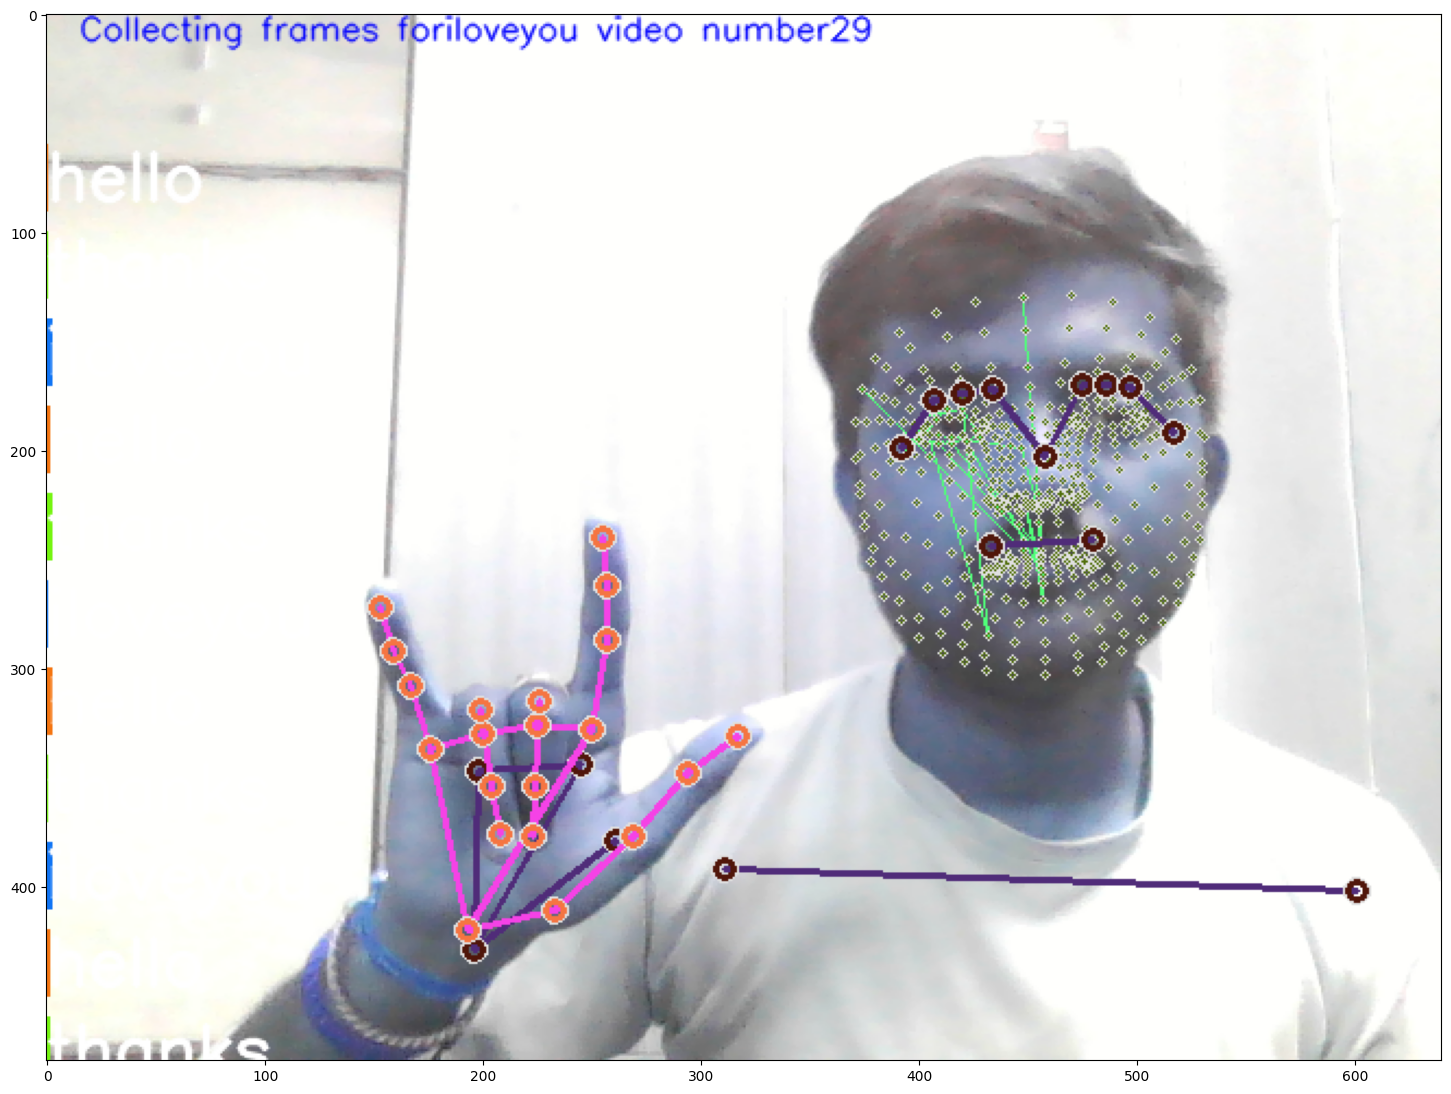

In [188]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        # print(num, prob, output_frame.shape)
        cv2.rectangle(output_frame, (0,60+num*40), ((prob*100).argmax(), 90+num*40), colors[num%3], -1)
        cv2.putText(output_frame, actions[num%3], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
  
    return output_frame
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res,actions,image,colors))

In [191]:
# 1. New detection variables 
sequence= []
sequence= []
predictions =[]
threshold = 0.4


cap = cv2.VideoCapture(0)
# SET MEDIAPIPE MODEL
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # MAKE DETECTIONS 
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.insert(0,keypoints)
        sequence=sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
        
        # viz logic
        if np.unique(predictions[-10:])[0]==np.argmax(res):
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                   if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
                else:
                      sentence.append(actions[np.argmax(res)])
                   
         
        if len(sentence) > 5:
            sentence = sentence[-5:]
        image = prob_viz(res,actions,image,colors)
        cv2.rectangle(image,(0,0),(640,40),(245,117,16),-1)
        cv2.putText(image,' '.join(sentence),(3,30),
                    cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        cv2.imshow('Opencv Feed', image)
    
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>


IndexError: index 0 is out of bounds for axis 0 with size 0

In [190]:
cap.release()
cv2.destroyAllwindows()

AttributeError: module 'cv2' has no attribute 'distroyAllwindows'

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
(num_sequences,30,1662)

In [ ]:
model.predict(np.expand_dims(x_test[0],axis=0))